In [42]:
import polars as pl
import os
import io
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

In [18]:
splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet', 'valid': 'data/valid-00000-of-00001.parquet'}
train_ds = pl.read_parquet('hf://datasets/rainerberger/Mri_segmentation/' + splits['train'])
test_ds = pl.read_parquet('hf://datasets/rainerberger/Mri_segmentation/' + splits['test'])
valid_ds = pl.read_parquet('hf://datasets/rainerberger/Mri_segmentation/' + splits['valid'])

In [19]:
train_ds.columns

['image', 'annotation']

In [7]:
type(train_ds['image'][0]['bytes'])

bytes

In [20]:
print("Validation dataset rows: ", len(valid_ds))
print("Validation dataset rows: ", len(train_ds))
print("Validation dataset rows: ", len(test_ds))

Validation dataset rows:  200
Validation dataset rows:  400
Validation dataset rows:  100


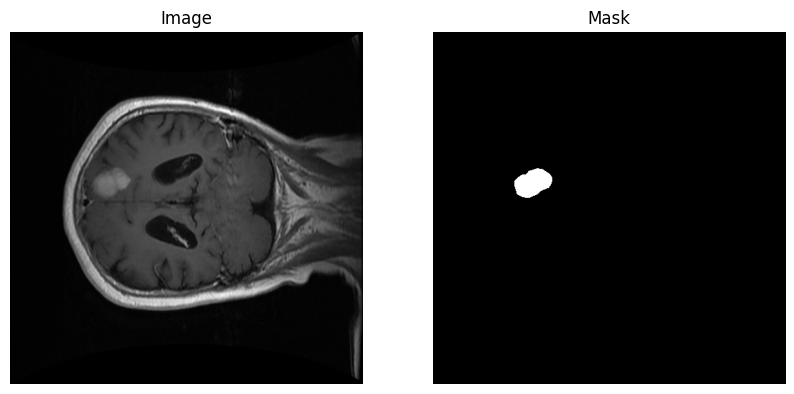

In [41]:
#@title Load into numpy arrays and normalize
def bytes_to_numpy(image_bytes):
    image = Image.open(io.BytesIO(image_bytes))
    return np.array(image)

x_train = [bytes_to_numpy(entry['bytes']).astype("float32") / 255 for entry in train_ds['image']]
y_train = [bytes_to_numpy(entry['bytes']).astype("int32") / 255 for entry in train_ds['annotation']]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image")
plt.axis("off")
plt.imshow(x_train[0], 'gray')

plt.subplot(1, 2, 2)
plt.title("Mask")
plt.axis("off")
plt.imshow(y_train[0], 'gray')
plt.show()

In [ ]:
BATCH_SIZE = 10
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = 512
NUM_CLASSES  = 1

In [43]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

## Prepare U-Net Xception-style model

In [ ]:
from keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Build model
model = get_model(img_size, num_classes)
model.summary()

## Set aside a validation split

In [ ]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate dataset for each split
# Limit input files in `max_dataset_len` for faster epoch training time.
# Remove the `max_dataset_len` arg when running with full dataset.
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
    max_dataset_len=1000,
)
valid_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

## Train the model

In [ ]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss="sparse_categorical_crossentropy"
)

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 50
model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=2,
)

## Visualize predictions

In [ ]:
# Generate predictions for all images in the validation set

val_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)
val_preds = model.predict(val_dataset)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.